In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge

from datetime import datetime, timedelta
from dateutil import relativedelta 
from time import mktime

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_timestamp(dt):
    format = "%Y-%m-%d"
    return int(mktime(datetime.strptime(dt, format).timetuple()))

In [3]:
ticker = 'BBCA'
period1 = get_timestamp('2011-11-28') # 28-11-2011
period2 = get_timestamp('2021-11-28') # 28-11-2021
interval = '1d'
url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}.JK?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
raw_data = pd.read_csv(url)

raw_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-11-28,1510.0,1520.0,1490.0,1510.0,1315.964355,71170000
1,2011-11-29,1540.0,1570.0,1510.0,1540.0,1342.109375,91865000
2,2011-11-30,1580.0,1590.0,1540.0,1580.0,1376.969482,100960000
3,2011-12-01,1580.0,1580.0,1580.0,1580.0,1376.969482,0
4,2011-12-02,1600.0,1600.0,1580.0,1600.0,1394.399170,25070000


In [4]:
raw_data = raw_data[['Date', 'Close']]
raw_data.head()

,Date,Close
0,2011-11-28,1510.0
1,2011-11-29,1540.0
2,2011-11-30,1580.0
3,2011-12-01,1580.0
4,2011-12-02,1600.0


In [5]:
raw_data.isna().sum()

Date     0
Close    0
dtype: int64

In [6]:
raw_data = raw_data.fillna(method='ffill')

In [7]:
raw_data.isna().sum()

Date     0
Close    0
dtype: int64

In [8]:
raw_data.shape

(2487, 2)

([], [])

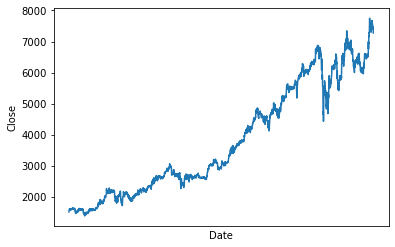

In [9]:
sns.lineplot(x='Date', y='Close', data=raw_data)
plt.xticks([])

In [10]:
window_size = 400
smooth_data = [raw_data.Close[i-window_size:i].mean() for i in range(window_size, raw_data.shape[0])]
data = pd.DataFrame({
    'Close': smooth_data
})
data['Target'] = data['Close'].shift(-1)
data = data.iloc[:-1]
data.tail()

,Close,Target
2081,6304.6625,6310.0250
2082,6310.0250,6314.9375
2083,6314.9375,6319.8875
2084,6319.8875,6324.7625
2085,6324.7625,6329.6250


In [11]:
X = data[['Close']]
X

,Close
0,1739.2500
1,1740.2000
2,1741.2500
3,1742.3500
4,1743.5000
...,...
2081,6304.6625
2082,6310.0250
2083,6314.9375
2084,6319.8875


In [12]:
y = data['Target']
y

0       1740.2000
1       1741.2500
2       1742.3500
3       1743.5000
4       1744.5500
          ...    
2081    6310.0250
2082    6314.9375
2083    6319.8875
2084    6324.7625
2085    6329.6250
Name: Target, Length: 2086, dtype: float64

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
model = Ridge()
model.fit(X_train, y_train)

Ridge()

In [15]:
model.score(X_test, y_test)

0.9993418161350397

In [16]:
def train_model(n_shift=1, window=400, alpha=1):
    smooth_data = [raw_data.Close[i-window_size:i].mean() for i in range(window_size, raw_data.shape[0])]
    data = pd.DataFrame({
        'Close': smooth_data
    })
    data['Target'] = data['Close'].shift(-n_shift)
    data = data.iloc[:-n_shift]
    X = data[['Close']]
    y = data['Target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    model = Ridge(alpha)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [17]:
train_model(n_shift=1)

0.9993418161350397

In [18]:
shifts = list(range(1,11))
alphas = [.0001, .0005, .001, .005, .01, .05, .1, .3]

params = [{"shift": s, "alpha": a} for s in shifts for a in alphas]

In [19]:
performance = pd.DataFrame({
    'shift': params,
    'score': [train_model(n_shift=i['shift'], alpha=i['alpha']) for i in params] 
})

In [20]:
performance.sort_values(by='score', ascending=False)

,shift,score
7,"{'shift': 1, 'alpha': 0.3}",0.999342
6,"{'shift': 1, 'alpha': 0.1}",0.999342
5,"{'shift': 1, 'alpha': 0.05}",0.999342
4,"{'shift': 1, 'alpha': 0.01}",0.999342
3,"{'shift': 1, 'alpha': 0.005}",0.999342
...,...,...
76,"{'shift': 10, 'alpha': 0.01}",0.933031
75,"{'shift': 10, 'alpha': 0.005}",0.933031
74,"{'shift': 10, 'alpha': 0.001}",0.933031
73,"{'shift': 10, 'alpha': 0.0005}",0.933031


In [21]:
final_model = Ridge(alpha = 0.3)
final_model.fit(X_train, y_train)

Ridge(alpha=0.3)

In [22]:
final_model.score(X_test, y_test)

0.9993418158577853

In [23]:
predict = final_model.predict(X_test)

In [24]:
test_data = pd.DataFrame({
    'Close': X_test['Close'],
    'Target': predict
})

In [25]:
test_data

,Close,Target
1668,5729.0750,5734.332012
1669,5732.6250,5737.885971
1670,5735.1500,5740.413787
1671,5738.0250,5743.291993
1672,5740.3625,5745.632099
...,...,...
2081,6304.6625,6310.561367
2082,6310.0250,6315.929846
2083,6314.9375,6320.847824
2084,6319.8875,6325.803344


In [26]:
from sklearn.metrics import r2_score

r2_score(test_data['Close'], predict)

0.9989457153568545

In [27]:
def train_model_for_ticker(ticker, date=datetime.today(), years=10):
    period1 = get_timestamp(date.replace(year=date.year - years).strftime("%Y-%m-%d"))
    period2 = get_timestamp(date.strftime("%Y-%m-%d"))
    interval = '1d'
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}.JK?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    raw_data = pd.read_csv(url)
    data = raw_data[['Date', 'Close']]
    data = data.fillna(method='ffill')
    
    def train_model(data, n_shift=1, alpha=1, window_size=400, final=False):
        last_data = data.iloc[-2:,:]
        smooth_data = [data.Close[i-window_size:i].mean() for i in range(window_size, data.shape[0])]
        data = pd.DataFrame({
            'Close': smooth_data
        })
        data['Target'] = data['Close'].shift(-n_shift)
        data = data.iloc[:-n_shift]
        X = data[['Close']]
        y = data['Target']
        model = Ridge(alpha)
        if not final:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
            model.fit(X_train, y_train)
            return model, model.score(X_test, y_test)
        else:
            model.fit(X, y)
            return {
                "model": model,
                "last_date": data.iloc[-1, 0],
                "Close": raw_data.iloc[-2,1],
                "Target": raw_data.iloc[-1,1]
            }
    
    alphas = [.0001, .001, .01, .1, 1]
    performance = pd.DataFrame({
        'alpha': alphas,
        'score': [train_model(data=data, alpha=a)[1] for a in alphas] 
    })
    best = performance.sort_values(by='score', ascending=False).iloc[0, 0]
            
    return train_model(data, alpha=best, final=True)   


In [28]:
tickers = ['BBCA', 'SIDO', 'BBNI', 'PTBA', 'BMRI', 'BJTM']
results = {ticker: train_model_for_ticker(ticker) for ticker in tickers}

In [29]:
models = pd.DataFrame(results).T
models

,model,last_date,Close,Target
BBCA,Ridge(),6342.9,7275.0,7375.0
SIDO,Ridge(),745.530937,915.0,900.0
BBNI,Ridge(),5385.95,6800.0,6650.0
PTBA,Ridge(),2322.5625,2580.0,2600.0
BMRI,Ridge(),5969.825,7000.0,7075.0
BJTM,Ridge(),673.3025,750.0,750.0


In [30]:
def predict_price(rows, n_years):
    model = rows.model
    prices = [rows.Target]
    days = n_years * 52
    for i in range(days):
        current = prices[i]
        predict = model.predict(np.array([current]).reshape(-1,1))
        prices.append(predict[0])
    return prices[1:]

In [31]:
def get_return(rows, n_years):
    prices = predict_price(rows, n_years)
    return prices[-1] / prices[0] - 1

def get_cagr(rows, n_years):
    rate = get_return(rows, n_years)
    return np.sign(rate) * abs(rate) ** (n_years * 52) - 1 

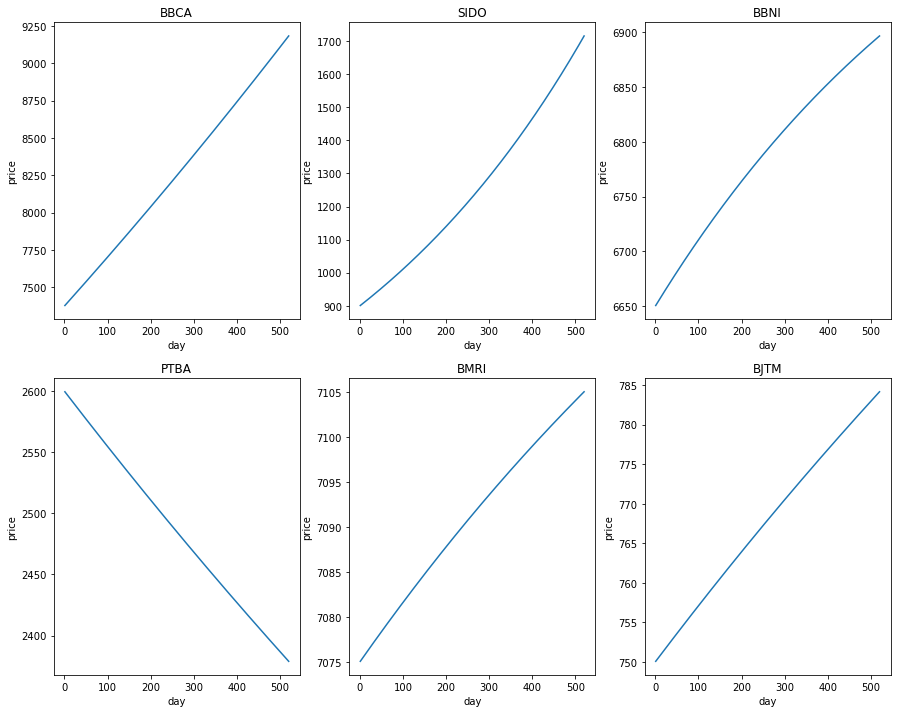

In [32]:
plt.figure(figsize=(15,12))
for i,ticker in enumerate(tickers):
    price_prediction = predict_price(models.loc[ticker], 10)
    plt.subplot(230+i+1)
    ax = sns.lineplot(x=list(range(1,len(price_prediction)+1)), y=price_prediction)
    ax.set_title(ticker)
    ax.set_xlabel('day')   
    ax.set_ylabel('price')

In [33]:
models.apply(lambda x: get_return(x, 10), axis=1)

BBCA    0.244570
SIDO    0.903481
BBNI    0.037003
PTBA   -0.084870
BMRI    0.004237
BJTM    0.045458
dtype: float64

In [34]:
get_return(models.loc['PTBA'], 10)

-0.08486966058300316